# Regressão multipla com dados do IBGE

Vamos utilizar um dataset de uma amostra da população brasileira para treinar nossos conceitos de regressão.

Nesse dataset temos informações sobre 66470 invidividuos pesquisados pelo censo e extraimos 8 variáveis:
- id
- idade
- sexo
- cor/raca
- salario
- estado_civil
- regiao
- Educação


Nossos pontos de interesse serão:

- Análise multivariada.
- Transformações nas distribuições para serem usadas em uma regressão.
- Tratamento de variáveis categóricas.
- O que seria afinal uma variável categórica?

Algumas perguntas que poderemos responder:

- Pessoas casadas ganham mais que pessoas solteiras?
- Existe diferença salarial entre as diferentes regiões do país?
- O salário aumenta com a idade?
- Vale a pena estudar mais para ganhar maiores salarios? Estudar até quando?

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
df = pd.read_csv(r'./data/data.csv')

In [5]:
df.head(10)

,Unnamed: 0,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte
1,1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte
2,2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte
5,5,1.100190e+10,30,mulher,15.0,Amarela,88550.000000,0.0,nordeste
6,6,1.100190e+10,52,mulher,5.0,Branca,6734.400391,0.0,norte
7,7,1.100190e+10,29,homem,5.0,Parda,14875.200684,0.0,norte
8,8,1.100190e+10,29,mulher,11.0,Parda,6734.400391,0.0,norte
9,9,1.100191e+10,46,mulher,15.0,Branca,54300.000000,1.0,norte


# Vamos olhar as estátisticas descritivas desses dados.

Contagens diferentes indicam campos nulos nessas variáveis -> Será que existe viés?

STD Muito altos indicam que existe outliners (ver max/min) distorcendo a amostra. Qual a origem desses pontos anormais? Gerarão viés?

Para dummies, a média representa a proporção das variáveis.

In [6]:
df.describe() # Apenas variáveis numéricas aparecem no describe

,Unnamed: 0,id,idade,anos_estudo,salario,estado_civil
count,66470.000000,6.647000e+04,66470.000000,66036.000000,47878.000000,66470.000000
mean,33234.500000,3.445307e+10,37.634813,8.686065,19706.790323,0.587724
std,19188.380534,1.292491e+10,11.380158,3.374522,88627.532024,0.492248
min,0.000000,1.100190e+10,20.000000,5.000000,-1.000000,0.000000
25%,16617.250000,3.110060e+10,28.000000,5.000000,3780.000000,0.000000
50%,33234.500000,3.316781e+10,37.000000,8.000000,7113.599609,1.000000
75%,49851.750000,4.310361e+10,47.000000,11.000000,12720.000000,1.000000
max,66469.000000,5.311702e+10,60.000000,15.000000,999999.000000,1.000000


Quantidade de linhas nulas para cada campo

In [7]:
df.isnull().sum().sort_values(ascending=False).head(4)

salario        18592
anos_estudo      434
cor/raca         242
regiao             0
dtype: int64

Transformando em percentual

In [8]:
(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False).head(4)

salario        0.279705
anos_estudo    0.006529
cor/raca       0.003641
regiao         0.000000
dtype: float64

In [9]:
# correlação entre todas as variaveis:
df.corr().round(4)

,Unnamed: 0,id,idade,anos_estudo,salario,estado_civil
Unnamed: 0,1.0000,0.9704,0.0450,0.0173,0.0182,0.0357
id,0.9704,1.0000,0.0520,0.0357,0.0223,0.0295
idade,0.0450,0.0520,1.0000,-0.2232,0.1222,0.2100
anos_estudo,0.0173,0.0357,-0.2232,1.0000,0.1014,-0.1188
salario,0.0182,0.0223,0.1222,0.1014,1.0000,0.0310
estado_civil,0.0357,0.0295,0.2100,-0.1188,0.0310,1.0000


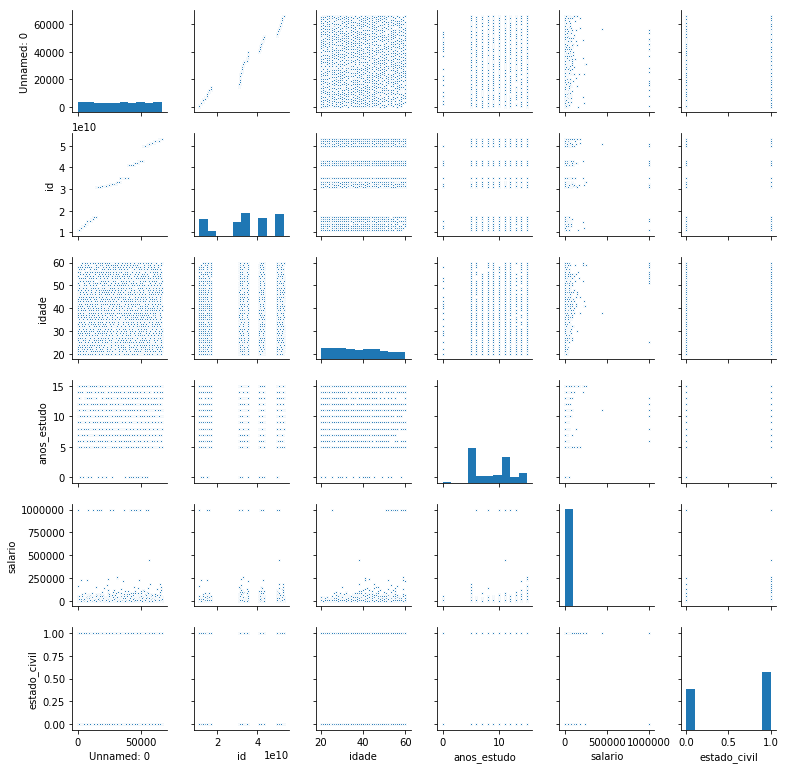

In [10]:
sns.pairplot(
    data=df.fillna(0).sample(5000),
    size=1.8,
    plot_kws={'s': 5})

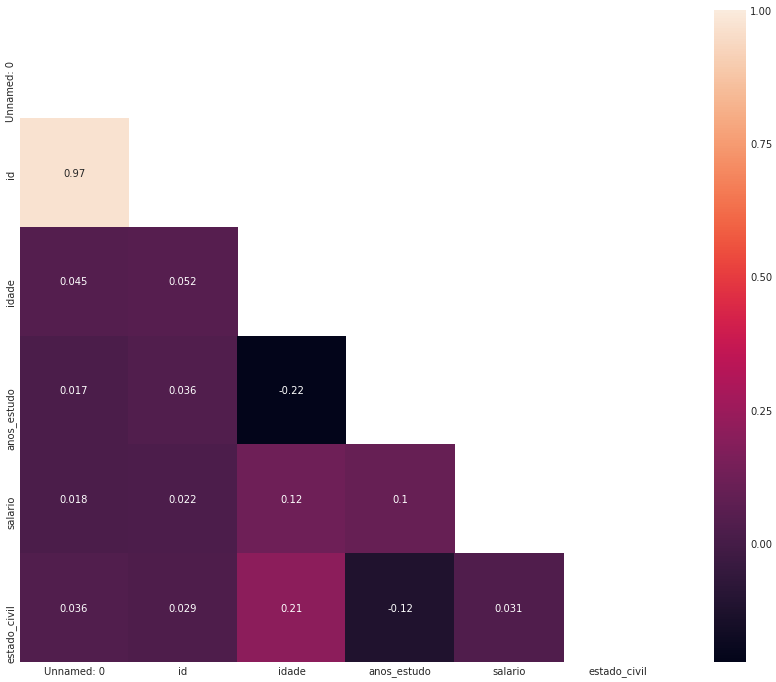

In [11]:
corr = df.corr()
mask = np.zeros_like(corr) # removendo valores zero
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 12));
    
    sns.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    );

# 1. Qual a relação entre idade e salario?

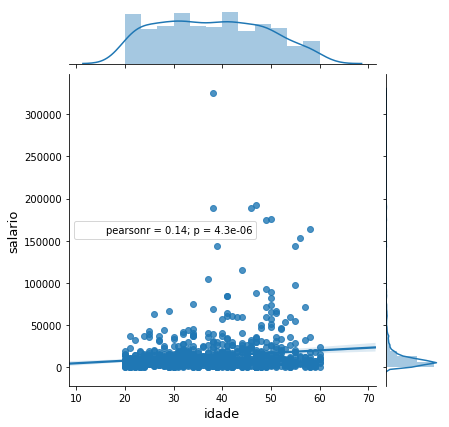

In [12]:
# Não nos ajuda a ver o que precisamos.
temp = df[df.salario<999999].sample(1000)
sns.jointplot(x="idade", y="salario", data=temp, kind='reg') # hue='estado_civil'
plt.ylabel('salario', fontsize=13)
plt.xlabel('idade', fontsize=13)
plt.show()

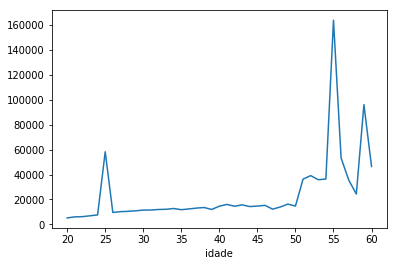

In [13]:
df.groupby('idade')['salario'].mean().plot()

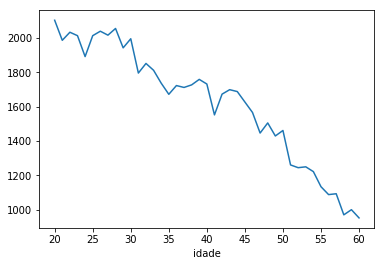

In [14]:
df.groupby('idade')['salario'].size().plot()

In [45]:
def run_regression(df,function):
    model = smf.ols(function, df).fit()
    print(model.summary())
    return model 

In [16]:
mascara = df.salario < 999999
run_regression(df[mascara],'salario ~ idade')

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     653.6
Date:                Tue, 12 Feb 2019   Prob (F-statistic):          3.43e-143
Time:                        12:07:47   Log-Likelihood:            -5.3961e+05
No. Observations:               47511   AIC:                         1.079e+06
Df Residuals:                   47509   BIC:                         1.079e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3702.7591    343.225     10.788      0.0

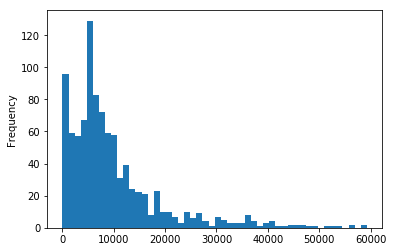

In [17]:
# Será que essa distribuição dos salarios é normal? 
temp[temp.salario<60000].salario.plot.hist(bins=50)

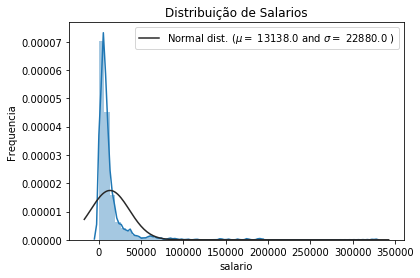

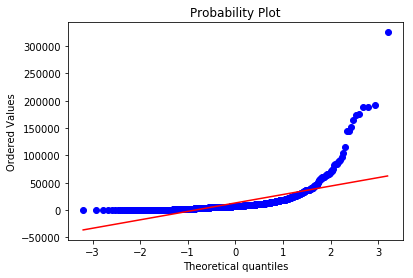

In [19]:
# Parece que não né, vamos comparar graficamente.
sns.distplot(temp['salario'].fillna(0), fit=stats.norm);

(mu, sigma) = stats.norm.fit(temp['salario'].fillna(0))
plt.legend([f'Normal dist. ($\mu=$ {round(mu,0)} and $\sigma=$ {round(sigma,0)} )'],loc='best')
plt.ylabel('Frequencia')
plt.title('Distribuição de Salarios')

fig = plt.figure()
res = stats.probplot(temp['salario'], plot=plt)
plt.show()

Para variáveis com valores "explosivos" ou com excesso de outliers (ou em casos mais complexos com excesso de [heterocedasticidade](https://pt.wikipedia.org/wiki/Heteroscedasticidade)) devemos [transformar](https://en.wikipedia.org/wiki/Data_transformation_(statistics) a amostra com a função log.

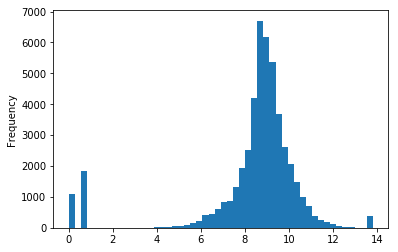

In [20]:
df['log_salario'] = np.log(df['salario']+2)
df['log_salario'].plot.hist(bins=50)

In [21]:
np.exp(9)

8103.083927575384

In [22]:
temp = df[(df.log_salario > 2) & (df.salario<999999)]

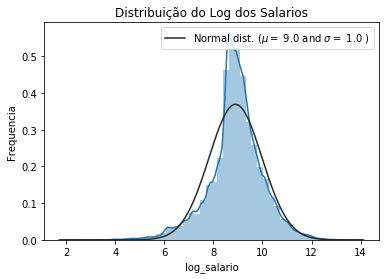

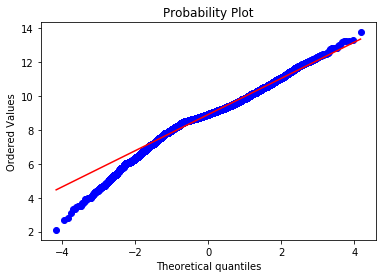

In [23]:
# Parece que não né, vamos comparar graficamente.
sns.distplot(temp['log_salario'].fillna(0), fit=stats.norm);

(mu, sigma) = stats.norm.fit(temp['log_salario'].fillna(0))
plt.legend([f'Normal dist. ($\mu=$ {round(mu,0)} and $\sigma=$ {round(sigma,0)} )'],loc='best')
plt.ylabel('Frequencia')
plt.title('Distribuição do Log dos Salarios')

fig = plt.figure()
res = stats.probplot(temp['log_salario'], plot=plt)
plt.show()

# 2. Qual a relação entre educação e salario?

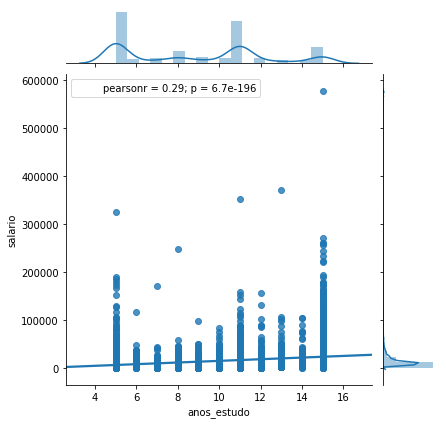

In [24]:
# Novamente a viz não nos ajuda a ver alguma relação.
sns.jointplot(x="anos_estudo", y="salario", data=temp.sample(10000), kind='reg') # hue='estado_civil'

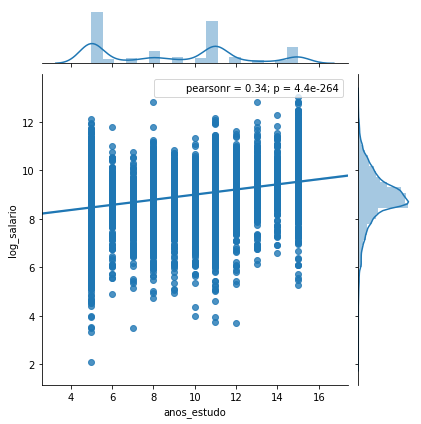

In [25]:
sns.jointplot(x="anos_estudo", y="log_salario", data=temp.sample(10000), kind='reg') # hue='estado_civil'

In [26]:
run_regression(temp,'salario ~ anos_estudo')

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4171.
Date:                Tue, 12 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:08:31   Log-Likelihood:            -5.0184e+05
No. Observations:               44243   AIC:                         1.004e+06
Df Residuals:                   44241   BIC:                         1.004e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3387.9726    271.150    -12.495      

In [27]:
run_regression(temp,'log_salario ~ anos_estudo')

                            OLS Regression Results                            
Dep. Variable:            log_salario   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6243.
Date:                Tue, 12 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:08:32   Log-Likelihood:                -63290.
No. Observations:               44243   AIC:                         1.266e+05
Df Residuals:                   44241   BIC:                         1.266e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.9101      0.013    588.615      

In [28]:
# Ao Adicionar idade na regressão de anos de estudo saimos da regressão simples e vamos
# para a regressão multipla, no output não muda quase nada, apenas uma linha a mais.
# Mas a interpretação muda muito! O parâmetro de anos de estudo deviam aumentar ou diminuir
# incluindo idade? Essa questão deixa de ser intuitiva ...

run_regression(temp,'log_salario ~ anos_estudo + idade')

                            OLS Regression Results                            
Dep. Variable:            log_salario   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     4387.
Date:                Tue, 12 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:08:34   Log-Likelihood:                -62208.
No. Observations:               44243   AIC:                         1.244e+05
Df Residuals:                   44240   BIC:                         1.244e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0103      0.023    302.528      

# Investigando a relação entre salário e estado civil

In [29]:
df[['salario', 'estado_civil']].head(10)

,salario,estado_civil
0,63600.000000,1.0
1,NaN,1.0
2,4352.400391,0.0
3,96600.000000,1.0
4,157800.000000,1.0
5,88550.000000,0.0
6,6734.400391,0.0
7,14875.200684,0.0
8,6734.400391,0.0
9,54300.000000,1.0


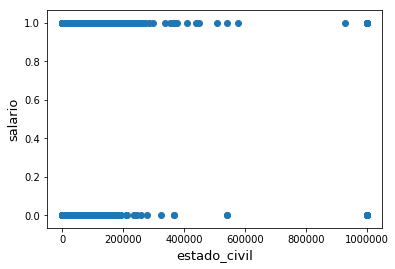

In [30]:
# Não nos ajuda a ver o que precisamos.
fig, ax = plt.subplots()
ax.scatter(x = df['salario'], y = df['estado_civil'])
plt.ylabel('salario', fontsize=13)
plt.xlabel('estado_civil', fontsize=13)
plt.show()

In [31]:
df[df.estado_civil == 1]['salario'].mean()

21893.607440356824

In [32]:
df[df.estado_civil == 1]['salario'].std()

93935.88880512808

In [33]:
df[df.estado_civil == 0]['salario'].mean()

16251.204448112616

In [34]:
df[df.estado_civil == 0]['salario'].std()

79399.95692962855

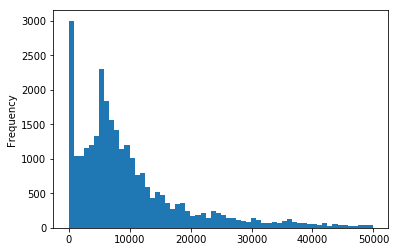

In [35]:
mascara_salario_alto = df.salario<50000
mascara_casado = df.estado_civil == 1
df[(mascara_salario_alto) & (mascara_casado)]['salario'].plot.hist(bins=60)

In [36]:
mascara_salario_baixo = df.salario > 50
mascara_casado = df.estado_civil == 1
mascara_nao_casado = df.estado_civil == 0

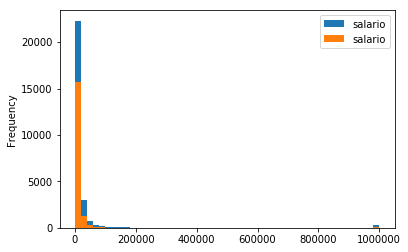

In [37]:
df[(mascara_salario_baixo) & (mascara_casado)]['salario'].plot.hist(bins=50)
df[(mascara_salario_baixo) & (mascara_nao_casado)]['salario'].plot.hist(bins=50)
plt.legend()
plt.show()

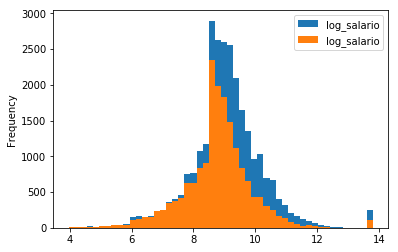

In [38]:
df[(mascara_salario_baixo) & (mascara_casado)]['log_salario'].plot.hist(bins=50)
df[(mascara_salario_baixo) & (mascara_nao_casado)]['log_salario'].plot.hist(bins=50)
plt.legend()
plt.show()

# Adicionando mais variáveis.

In [82]:
function1 = '''log_salario ~ sexo + idade + anos_estudo + estado_civil'''

model1 = smf.ols(function1, temp.dropna()).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            log_salario   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     2892.
Date:                Tue, 12 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:24:59   Log-Likelihood:                -59759.
No. Observations:               44111   AIC:                         1.195e+05
Df Residuals:                   44105   BIC:                         1.196e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.5177      0.196     33.

In [70]:
# O que o statsmodel fez foi criar uma dummy, ou seja, um valor categórico que assume 0 ou 1.
# Em outros algoritmos temos que fazer isso explicitamente.

pd.get_dummies(df).head(10)

,Unnamed: 0,id,idade,anos_estudo,salario,estado_civil,log_salario,sexo_gestante,sexo_homem,sexo_mulher,cor/raca_Amarela,cor/raca_Branca,cor/raca_Indigena,cor/raca_Parda,cor/raca_Preta,regiao_centro-oeste,regiao_nordeste,regiao_norte,regiao_sudeste,regiao_sul
0,0,1.100190e+10,53,5.0,63600.000000,1.0,11.060400,0,1,0,0,0,0,1,0,0,0,1,0,0
1,1,1.100190e+10,49,8.0,NaN,1.0,NaN,0,0,1,1,0,0,0,0,0,0,1,0,0
2,2,1.100190e+10,22,11.0,4352.400391,0.0,8.378942,0,0,1,0,0,1,0,0,0,1,0,0,0
3,3,1.100190e+10,55,15.0,96600.000000,1.0,11.478355,0,1,0,1,0,0,0,0,0,0,1,0,0
4,4,1.100190e+10,56,15.0,157800.000000,1.0,11.969096,0,0,1,1,0,0,0,0,0,0,1,0,0
5,5,1.100190e+10,30,15.0,88550.000000,0.0,11.391345,0,0,1,1,0,0,0,0,0,1,0,0,0
6,6,1.100190e+10,52,5.0,6734.400391,0.0,8.815281,0,0,1,0,1,0,0,0,0,0,1,0,0
7,7,1.100190e+10,29,5.0,14875.200684,0.0,9.607585,0,1,0,0,0,0,1,0,0,0,1,0,0
8,8,1.100190e+10,29,11.0,6734.400391,0.0,8.815281,0,0,1,0,0,0,1,0,0,0,1,0,0
9,9,1.100191e+10,46,15.0,54300.000000,1.0,10.902316,0,0,1,0,1,0,0,0,0,0,1,0,0


# Deep Dive nos pré-requisitos do modelo de regressão Linear

In [71]:
model1.resid[:5]

0    2.084027
2   -0.038713
3    1.073494
4    2.125600
5    2.264118
dtype: float64

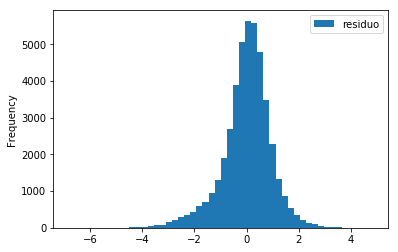

In [73]:
pd.DataFrame(model1.resid, columns=['residuo']).plot.hist(bins=50)

In [74]:
yhat = model1.predict()
yhat[:10]

array([ 8.9763728 ,  8.41765494, 10.40486053,  9.84349666,  9.12722772,
        8.15933231,  8.29848655,  8.55199436,  9.6515832 ,  9.79124447])

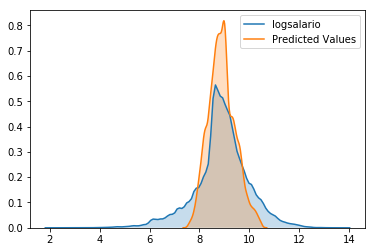

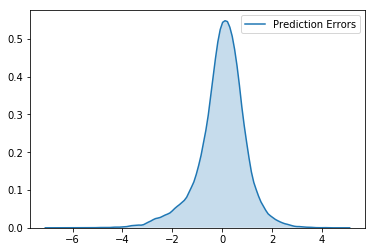

In [76]:
sns.kdeplot(ytrue, shade=True, label='logsalario')
sns.kdeplot(yhat, shade=True, label='Predicted Values')
plt.show()
sns.kdeplot(model1.resid, shade=True, label='Prediction Errors');

As variáveis tem uma relação linear?

Text(0.5,1,'Linear Regression')

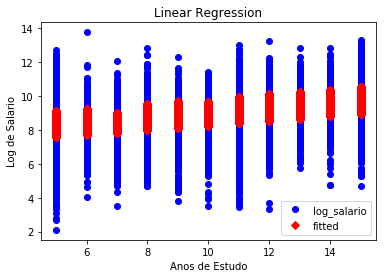

In [80]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model1, 4, ax=ax)
ax.set_ylabel("Log de Salario")
ax.set_xlabel("Anos de Estudo")
ax.set_title("Linear Regression")

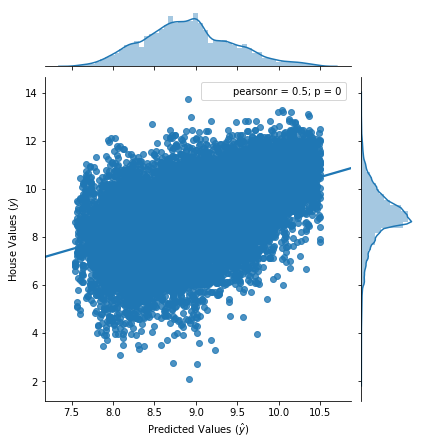

In [85]:
sns.jointplot(model1.predict(), temp.dropna()['log_salario'], kind='reg')
plt.xlabel('Predicted Values ($\hat y$)')
plt.ylabel('House Values ($y$)');

Os erros são independentes?

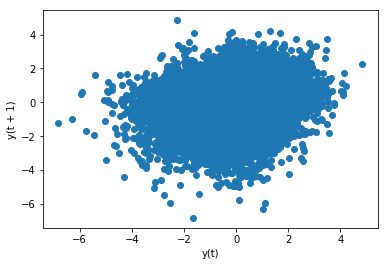

In [88]:
# Em uma cross-section precisamos entender como os dados foram construidos.
# Em uma série de tempo/espaço analisamos se o tempo atual tem relação com o tempo passado. 
# ou no espaço, se a posição atual tem relação com as posições ao redor.
from pandas.plotting import lag_plot
lag_plot(temp.dropna()['log_salario']-model1.predict())

Os erros tem distribuição normal?

In [ ]:
# Plotar a distribuição/histograma e comparar com uma curva normal geralmente é suficiente
# para dizer que nossos erros/rezidos são normalmente distribuidos.
# do contrário podemos supor que existe alguma variável importante que não foi incluida no modelo
# e portanto tornando nossos parâmetros betas estimados enviesados.
# Com uma amostra de reduzidos normalmente distribuida, há mais indicios para dizer que ela é
# causada por alguma aleatoriedade. Mais uma palavra para nosso vocabulario é "idiossincratico"
# que sifnifica basicamente que o que explica a diferença dos valores previstos para os observados
# são causados por coisas muito particulares das observações que não devem ser consideradas no modelo,
# a essas caracteristicas particulares damos o nome de caracteristicas idiossincraticas.

In [89]:
from scipy.stats import normaltest
normaltest(temp.dropna()['log_salario']-model1.predict())

NormaltestResult(statistic=5081.388385178984, pvalue=0.0)

In [ ]:
# A variância sigma2 das variaveis não dependem no nível da variável (são constantes)